# Generating Cell Embeddings with RegFormer

In this tutorial, we will demonstrate how to apply a pre-trained RegFormer model to generate meaningful cell embeddings from a new single-cell dataset.

## 1.Execute the code

In [1]:
import os
import sys

sys.path.insert(0, "/home/share/huadjyin/home/s_huluni/project/RegFormer")
from downstream_task.regformer_emb import EmbTaskMamba

config_file = "cell_emb_human_lung.toml"
task = EmbTaskMamba(config_file)

print(f"[INFO] Run name: {task.args.run_name}")
task.run_embedding()

Save to /home/share/huadjyin/home/s_huluni/project/RegFormer/case/tutorials/cell_emb/saves/emb_10k_human_lung
[INFO] Run name: emb_10k_human_lung
scMamba - INFO - Resume model from /home/share/huadjyin/home/s_huluni/project/RegFormer/case/02_pretrain/models/Pretraining/cellxgene/mamba/pt_graph_sort_avg_pool_all_length/best_model.pt, the model args will override the config /home/share/huadjyin/home/s_huluni/project/RegFormer/case/02_pretrain/models/Pretraining/cellxgene/mamba/pt_graph_sort_avg_pool_all_length/args.json.


/home/share/huadjyin/home/s_huluni/anaconda3/envs/py39_torch/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


scMamba - INFO - match 22620/30783 genes in vocabulary of size 60698.


/home/share/huadjyin/home/s_huluni/project/RegFormer/regformer/data/preprocess.py:130: ImplicitModificationWarning: Setting element `.layers['X_normed']` of view, initializing view as actual.
  adata.layers[self.result_normed_key] = adata.X


scMamba - INFO - ✅ Normalized data saved to layers['X_normed']
scMamba - INFO - 📝 Pre-log data saved to layers['X_log1p']
scMamba - INFO - 🔍 Selecting HVGs ...


/home/share/huadjyin/home/s_huluni/anaconda3/envs/py39_torch/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


scMamba - INFO - 🎲 Binning with 51 bins ...
scMamba - INFO - ✅ Binned data saved to layers['X_binned']
scMamba - INFO - train set number of samples: 39778, 
	 feature length: 10000
Ratio of masked values in train:  0.0000
>>> Init parameters:
ntoken = 60698
d_model = 512
nlayers = 10
nlayers_cls = 3
device = cuda:1
ssm_cfg = None
norm_epsilon = 1e-05
rms_norm = False
fused_add_norm = False
residual_in_fp32 = False
initializer_cfg = None
n_cls = 1
vocab = GeneVocab()
dropout = 0.2
pad_token = <pad>
pad_value = -2
do_mvc = True
do_dab = False
do_cce = False
use_batch_labels = False
num_batch_labels = None
domain_spec_batchnorm = False
input_emb_style = continuous
n_input_bins = 51
cell_emb_style = avg-pool
mvc_decoder_style = inner product
ecs_threshold = 0.3
explicit_zero_prob = False
pre_norm = False
do_pretrain = True
topo_graph = True
init_layer_scale = None
if_bimamba = False
bimamba_type = none
do_pert = False
pert_pad_id = 2
token_emb_freeze = False
only_value_emb = False
bin_cls 

Embedding: 100%|██████████| 622/622 [08:29<00:00,  1.22it/s]


[0]
[0 1 2 3 4 5 6 7 8]
scMamba - INFO - AWS score: 0.6464
scMamba - INFO - Embedding complete.


## 2. Inspect and Analyze Results


In [6]:
import os
import numpy as np
import scanpy as sc
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt


# Define the path to the directory where your results are saved
results_dir = "/home/share/huadjyin/home/s_huluni/project/RegFormer/case/tutorials/cell_emb/saves/emb_10k_human_lung"

#    Provide the path to the ORIGINAL AnnData (.h5ad) file that you used as input for the script.
#    This file is needed to get the cell type labels for plotting and evaluation.
adata_path = "/home/share/huadjyin/home/s_huluni/project/RegFormer/case/03_cell_emb/data/human_lung.h5ad"
cell_type_key = 'cell_type'

# --- Configure plot styles ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12

In [2]:
# --- Load the generated cell embeddings ---
embedding_path = os.path.join(results_dir, 'cell_embedding.npy')
try:
    embeddings = np.load(embedding_path)
    print(f"✅ Successfully loaded embeddings from {embedding_path}")
    print(f"   Embedding shape: {embeddings.shape}")
except FileNotFoundError:
    print(f"❌ Error: The file 'cell_embedding.npy' was not found in '{results_dir}'")
    embeddings = None

# --- Load the original AnnData object ---
try:
    adata = sc.read_h5ad(adata_path)
    print(f"✅ Successfully loaded AnnData object from {adata_path}")
    print(f"   AnnData shape: {adata.shape}")
except (FileNotFoundError, NameError):
    print(f"❌ Error: The AnnData file was not found. Please check the 'adata_path' variable in the cell above.")
    adata = None

# --- Combine embeddings with AnnData ---
if adata is not None and embeddings is not None:
    # Sanity check: ensure the number of cells matches the number of embeddings
    if adata.n_obs == embeddings.shape[0]:
        # Add the embeddings to the .obsm slot of the AnnData object
        adata.obsm['X_regformer'] = embeddings
        print("\n✅ Embeddings have been successfully added to the AnnData object in '.obsm[\"X_regformer\"]'.")
    else:
        print(f"\n❌ Error: Mismatch in dimensions! Number of cells ({adata.n_obs}) does not match number of embeddings ({embeddings.shape[0]}).")

✅ Successfully loaded embeddings from /home/share/huadjyin/home/s_huluni/project/RegFormer/case/tutorials/cell_emb/saves/emb_10k_human_lung/cell_embedding.npy
   Embedding shape: (39778, 512)
✅ Successfully loaded AnnData object from /home/share/huadjyin/home/s_huluni/project/RegFormer/case/03_cell_emb/data/human_lung.h5ad
   AnnData shape: (39778, 30783)

✅ Embeddings have been successfully added to the AnnData object in '.obsm["X_regformer"]'.


Generating UMAP plot, colored by 'cell_type'...


/home/share/huadjyin/home/s_huluni/anaconda3/envs/py39_torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/share/huadjyin/home/s_huluni/anaconda3/envs/py39_torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


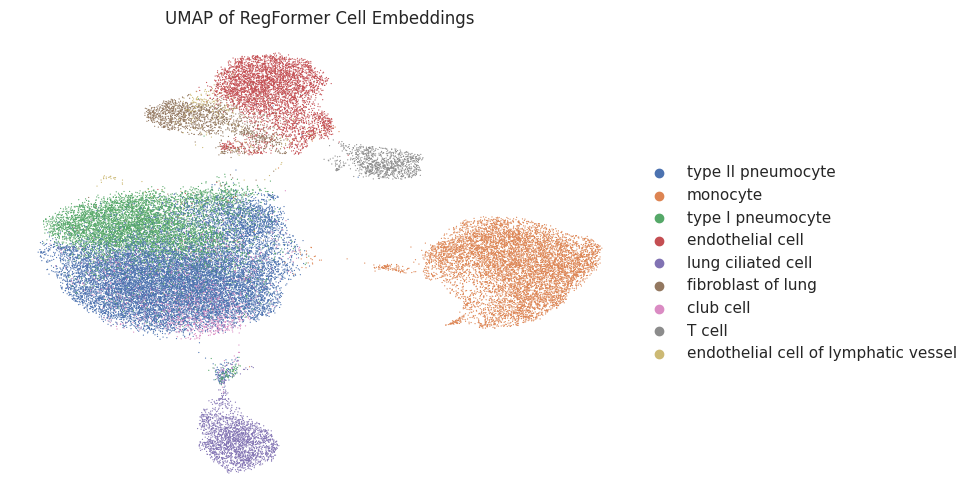

In [7]:
# --- Visualize Embeddings using UMAP ---
if adata is not None and 'X_regformer' in adata.obsm:
    print(f"Generating UMAP plot, colored by '{cell_type_key}'...")

    # Run the standard Scanpy workflow for visualization on our embeddings
    sc.pp.neighbors(adata, use_rep='X_regformer', n_neighbors=15)
    sc.tl.umap(adata)

    # Plot the UMAP
    sc.pl.umap(
        adata,
        color=cell_type_key,
        title='UMAP of RegFormer Cell Embeddings',
        frameon=False
    )
else:
    print("Cannot generate UMAP because embeddings are not loaded into the AnnData object.")

In [8]:
# --- Quantitative Evaluation ---
if adata is not None and 'X_regformer' in adata.obsm:
    print(f"Calculating Silhouette Score based on '{cell_type_key}' labels...")

    # Extract the labels and embeddings
    labels = adata.obs[cell_type_key].values

    # Calculate the silhouette score using cosine distance, as it's common for high-dim data
    # A score closer to +1 indicates better separation.
    s_score = silhouette_score(embeddings, labels, metric='cosine')

    # The original script calculates a scaled version (0 to 1), let's calculate both
    aws_score = (1 + s_score) / 2

    print("\n--- Embedding Quality Metrics ---")
    print(f"Silhouette Score (Cosine): {s_score:.4f}  (Range: -1 to +1)")
    print(f"Scaled Silhouette (AWS) : {aws_score:.4f}  (Range: 0 to 1)")
    print("Higher scores indicate better separation of cell types.")

else:
    print("Cannot calculate scores because embeddings are not loaded into the AnnData object.")

Calculating Silhouette Score based on 'cell_type' labels...

--- Embedding Quality Metrics ---
Silhouette Score (Cosine): 0.2929  (Range: -1 to +1)
Scaled Silhouette (AWS) : 0.6464  (Range: 0 to 1)
Higher scores indicate better separation of cell types.
